In [1]:
import numpy as np
import pandas as pd
import os
import joblib
import math

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from img2vec import grayscale2emb

### Load data

In [2]:
data_dir = os.path.join('..', '..', 'data')
train_data = pd.read_csv(os.path.join(data_dir, 'train.csv'))
val_data = pd.read_csv(os.path.join(data_dir, 'val.csv'))
test_data = pd.read_csv(os.path.join(data_dir, 'test.csv'))

### check if images exist and filter

In [3]:
def construct_img_path(row):
    return os.path.join(data_dir, 'faces', row['user_id'], 
                       f"coarse_tilt_aligned_face.{row['face_id']}.{row['original_image']}")

train_data['img_path'] = train_data.apply(construct_img_path, axis=1)
val_data['img_path'] = val_data.apply(construct_img_path, axis=1)
test_data['img_path'] = test_data.apply(construct_img_path, axis=1)

train_data['img_exists'] = train_data['img_path'].apply(os.path.exists)
val_data['img_exists'] = val_data['img_path'].apply(os.path.exists)
test_data['img_exists'] = test_data['img_path'].apply(os.path.exists)

# Filter to include only rows where images exist
train_data = train_data[train_data['img_exists'] == True]
val_data = val_data[val_data['img_exists'] == True]
test_data = test_data[test_data['img_exists'] == True]

### encode labels

In [4]:
if os.path.exists('age_encoder.pkl') and os.path.exists('gender_encoder.pkl'):
    age_encoder = joblib.load('age_encoder.pkl')
    gender_encoder = joblib.load('gender_encoder.pkl')
    print("Age and gender encoders loaded successfully.")
    
    # Add these lines to encode train data when loading existing encoders
    train_data['age_encoded'] = age_encoder.transform(train_data['age'])
    train_data['gender_encoded'] = gender_encoder.transform(train_data['gender'])
else:
    # Remove rare classes
    age_counts = train_data['age'].value_counts()
    gender_counts = train_data['gender'].value_counts()
    rare_ages = age_counts[age_counts < 5].index.tolist()
    rare_genders = gender_counts[gender_counts < 5].index.tolist()
    
    # Filter data
    train_data = train_data[~train_data['age'].isin(rare_ages) & ~train_data['gender'].isin(rare_genders)]
    
    # Create encoders
    age_encoder = LabelEncoder()
    gender_encoder = LabelEncoder()
    train_data['age_encoded'] = age_encoder.fit_transform(train_data['age'])
    train_data['gender_encoded'] = gender_encoder.fit_transform(train_data['gender'])
    
    # Save encoders
    joblib.dump(age_encoder, 'age_encoder.pkl')
    joblib.dump(gender_encoder, 'gender_encoder.pkl')
    print("Encoders created and saved.")

# Filter validation and test data to include only seen classes
val_data = val_data[val_data['age'].isin(age_encoder.classes_)]
val_data = val_data[val_data['gender'].isin(gender_encoder.classes_)]
test_data = test_data[test_data['age'].isin(age_encoder.classes_)]
test_data = test_data[test_data['gender'].isin(gender_encoder.classes_)]

# Encode the labels
val_data['age_encoded'] = age_encoder.transform(val_data['age'])
val_data['gender_encoded'] = gender_encoder.transform(val_data['gender'])
test_data['age_encoded'] = age_encoder.transform(test_data['age'])
test_data['gender_encoded'] = gender_encoder.transform(test_data['gender'])

num_age_classes = len(age_encoder.classes_)
num_gender_classes = len(gender_encoder.classes_)
print(f"Age classes: {age_encoder.classes_}")
print(f"Gender classes: {gender_encoder.classes_}")


Encoders created and saved.
Age classes: ['(0, 2)' '(15, 20)' '(25, 32)' '(38, 43)' '(4, 6)' '(48, 53)' '(60, 100)'
 '(8, 23)']
Gender classes: ['f' 'm' 'u']


### Define function that process features in batches and store them to avoid recomputation

In [5]:
def preprocess_and_save_features(image_paths, output_file, batch_size=64):
    if os.path.exists(output_file):
        print(f"Loading pre-processed features from {output_file}")
        return np.load(output_file)

    print(f"Processing {len(image_paths)} images and saving to {output_file}")
    all_features = []

    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i + batch_size]
        print(f"Processing batch {i // batch_size + 1}/{math.ceil(len(image_paths) / batch_size)}")
        batch_features = grayscale2emb(batch_paths)
        all_features.append(batch_features)

    all_features = np.vstack(all_features)
    np.save(output_file, all_features)
    return all_features

### Process and save features

In [6]:
if not os.path.exists('train_features.npy'):
    train_features = preprocess_and_save_features(train_data['img_path'].tolist(), 'train_features.npy')
    val_features = preprocess_and_save_features(val_data['img_path'].tolist(), 'val_features.npy')
    test_features = preprocess_and_save_features(test_data['img_path'].tolist(), 'test_features.npy')
else:
    train_features = np.load('train_features.npy')
    val_features = np.load('val_features.npy')
    test_features = np.load('test_features.npy')


Processing 11856 images and saving to train_features.npy
Processing batch 1/186
Processing batch 2/186
Processing batch 3/186
Processing batch 4/186
Processing batch 5/186
Processing batch 6/186
Processing batch 7/186
Processing batch 8/186
Processing batch 9/186
Processing batch 10/186
Processing batch 11/186
Processing batch 12/186
Processing batch 13/186
Processing batch 14/186
Processing batch 15/186
Processing batch 16/186
Processing batch 17/186
Processing batch 18/186
Processing batch 19/186
Processing batch 20/186
Processing batch 21/186
Processing batch 22/186
Processing batch 23/186
Processing batch 24/186
Processing batch 25/186
Processing batch 26/186
Processing batch 27/186
Processing batch 28/186
Processing batch 29/186
Processing batch 30/186
Processing batch 31/186
Processing batch 32/186
Processing batch 33/186
Processing batch 34/186
Processing batch 35/186
Processing batch 36/186
Processing batch 37/186
Processing batch 38/186
Processing batch 39/186
Processing batch

### Standardize features

In [7]:
if os.path.exists('feature_scaler.pkl'):
    scaler = joblib.load('feature_scaler.pkl')
    print("Feature scaler loaded successfully.")
else:
    scaler = StandardScaler()
    scaler.fit(train_features)
    joblib.dump(scaler, 'feature_scaler.pkl')
    print("Feature scaler created and saved.")

train_features_scaled = scaler.transform(train_features)
val_features_scaled = scaler.transform(val_features)
test_features_scaled = scaler.transform(test_features)

Feature scaler created and saved.


### Define model

In [8]:
def create_age_model(input_dim, num_age_classes):
    input_layer = Input(shape=(input_dim,))
    
    x = Dense(256, activation='relu')(input_layer)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    
    age_output = Dense(num_age_classes, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=age_output)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Gender prediction model
def create_gender_model(input_dim, num_gender_classes):
    input_layer = Input(shape=(input_dim,))
    
    x = Dense(256, activation='relu')(input_layer)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    
    gender_output = Dense(num_gender_classes, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=gender_output)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create models
age_model = create_age_model(train_features.shape[1], num_age_classes)
gender_model = create_gender_model(train_features.shape[1], num_gender_classes)

# Define callbacks for age model
age_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        'best_age_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Define callbacks for gender model
gender_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        'best_gender_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

### Compute class weights and get labels

In [9]:
train_age_labels = train_data['age_encoded'].values
train_gender_labels = train_data['gender_encoded'].values
val_age_labels = val_data['age_encoded'].values
val_gender_labels = val_data['gender_encoded'].values

age_weights = compute_class_weight('balanced', classes=np.unique(train_data['age_encoded']), 
                                  y=train_data['age_encoded'])
gender_weights = compute_class_weight('balanced', classes=np.unique(train_data['gender_encoded']), 
                                     y=train_data['gender_encoded'])

### Train models

In [10]:
print("Training the age model...")
age_history = age_model.fit(
    train_features_scaled,
    train_age_labels,
    validation_data=(val_features_scaled, val_age_labels),
    epochs=30,
    batch_size=64,
    callbacks=age_callbacks,
    class_weight=dict(enumerate(age_weights))
)

# Train gender model
print("Training the gender model...")
gender_history = gender_model.fit(
    train_features_scaled,
    train_gender_labels,
    validation_data=(val_features_scaled, val_gender_labels),
    epochs=30,
    batch_size=64,
    callbacks=gender_callbacks,
    class_weight=dict(enumerate(gender_weights))
)

Training the age model...
Epoch 1/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2542 - loss: 2.1296
Epoch 1: val_loss improved from inf to 1.35002, saving model to best_age_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.2545 - loss: 2.1282 - val_accuracy: 0.4467 - val_loss: 1.3500
Epoch 2/30
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3960 - loss: 1.4594
Epoch 2: val_loss improved from 1.35002 to 1.24701, saving model to best_age_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3961 - loss: 1.4589 - val_accuracy: 0.4936 - val_loss: 1.2470
Epoch 3/30
180/186 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4505 - loss: 1.2900
Epoch 3: val_loss improved from 1.24701 to 1.17075, saving model to best_age_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4506 - loss: 1.2898 - val_accuracy: 0.5412 - val_loss: 1.1708
Epoch 4/30
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5104 - loss: 1.1708
Epoch 4: val_loss improved from 1.17075 to 1.11186, saving model to best_age_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5102 - loss: 1.1709 - val_accuracy: 0.5644 - val_loss: 1.1119
Epoch 5/30
182/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5176 - loss: 1.1211
Epoch 5: val_loss improved from 1.11186 to 1.10337, saving model to best_age_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5176 - loss: 1.1209 - val_accuracy: 0.5587 - val_loss: 1.1034
Epoch 6/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5498 - loss: 1.0329
Epoch 6: val_loss improved from 1.10337 to 1.07926, saving model to best_age_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5498 - loss: 1.0329 - val_accuracy: 0.5584 - val_loss: 1.0793
Epoch 7/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5558 - loss: 0.9937
Epoch 7: val_loss improved from 1.07926 to 1.06577, saving model to best_age_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5559 - loss: 0.9937 - val_accuracy: 0.5722 - val_loss: 1.0658
Epoch 8/30
180/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5949 - loss: 0.9246
Epoch 8: val_loss improved from 1.06577 to 1.05593, saving model to best_age_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5946 - loss: 0.9253 - val_accuracy: 0.5709 - val_loss: 1.0559
Epoch 9/30
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6009 - loss: 0.8845
Epoch 9: val_loss improved from 1.05593 to 1.00399, saving model to best_age_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6008 - loss: 0.8849 - val_accuracy: 0.6056 - val_loss: 1.0040
Epoch 10/30
179/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6113 - loss: 0.8607
Epoch 10: val_loss improved from 1.00399 to 1.00279, saving model to best_age_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6111 - loss: 0.8610 - val_accuracy: 0.6019 - val_loss: 1.0028
Epoch 11/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6270 - loss: 0.8088
Epoch 11: val_loss did not improve from 1.00279
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6270 - loss: 0.8089 - val_accuracy: 0.6100 - val_loss: 1.0156
Epoch 12/30
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6469 - loss: 0.7739
Epoch 12: val_loss improved from 1.00279 to 0.98035, saving model to best_age_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6468 - loss: 0.7741 - val_accuracy: 0.6198 - val_loss: 0.9804
Epoch 13/30
179/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6561 - loss: 0.7428
Epoch 13: val_loss did not improve from 0.98035
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6560 - loss: 0.7429 - val_accuracy: 0.6312 - val_loss: 0.9839
Epoch 14/30
178/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6780 - loss: 0.6977
Epoch 14: val_loss improved from 0.98035 to 0.97358, saving model to best_age_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6777 - loss: 0.6982 - val_accuracy: 0.6356 - val_loss: 0.9736
Epoch 15/30
181/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6733 - loss: 0.6785
Epoch 15: val_loss did not improve from 0.97358
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6733 - loss: 0.6790 - val_accuracy: 0.6215 - val_loss: 1.0002
Epoch 16/30
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6971 - loss: 0.6387
Epoch 16: val_loss did not improve from 0.97358
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6970 - loss: 0.6387 - val_accuracy: 0.6272 - val_loss: 0.9798
Epoch 17/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6995 - loss: 0.6296
Epoch 17: val_loss did not improve from 0.97358
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6995 - loss: 0.6296 - val_accuracy: 0.6231 - val_loss: 0.9986
Epoch 18/30
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7072 - loss: 0.6178
Epoch 18: val_loss did not improve from 

186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5702 - loss: 0.9009 - val_accuracy: 0.8060 - val_loss: 0.5137
Epoch 2/30
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7668 - loss: 0.4952
Epoch 2: val_loss improved from 0.51370 to 0.46066, saving model to best_gender_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7669 - loss: 0.4951 - val_accuracy: 0.8215 - val_loss: 0.4607
Epoch 3/30
183/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8062 - loss: 0.4006
Epoch 3: val_loss improved from 0.46066 to 0.38439, saving model to best_gender_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8062 - loss: 0.4007 - val_accuracy: 0.8468 - val_loss: 0.3844
Epoch 4/30
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8315 - loss: 0.3546
Epoch 4: val_loss did not improve from 0.38439
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8315 - loss: 0.3547 - val_accuracy: 0.8411 - val_loss: 0.4027
Epoch 5/30
180/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8402 - loss: 0.3368
Epoch 5: val_loss improved from 0.38439 to 0.35242, saving model to best_gender_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8402 - loss: 0.3367 - val_accuracy: 0.8596 - val_loss: 0.3524
Epoch 6/30
180/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8521 - loss: 0.3088
Epoch 6: val_loss improved from 0.35242 to 0.34338, saving model to best_gender_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8522 - loss: 0.3087 - val_accuracy: 0.8596 - val_loss: 0.3434
Epoch 7/30
178/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8677 - loss: 0.2812
Epoch 7: val_loss did not improve from 0.34338
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8676 - loss: 0.2814 - val_accuracy: 0.8701 - val_loss: 0.3472
Epoch 8/30
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8644 - loss: 0.2902
Epoch 8: val_loss improved from 0.34338 to 0.33509, saving model to best_gender_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8645 - loss: 0.2899 - val_accuracy: 0.8674 - val_loss: 0.3351
Epoch 9/30
181/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8915 - loss: 0.2348
Epoch 9: val_loss improved from 0.33509 to 0.31788, saving model to best_gender_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8914 - loss: 0.2348 - val_accuracy: 0.8728 - val_loss: 0.3179
Epoch 10/30
180/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8964 - loss: 0.2130
Epoch 10: val_loss did not improve from 0.31788
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8962 - loss: 0.2134 - val_accuracy: 0.8755 - val_loss: 0.3203
Epoch 11/30
182/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8968 - loss: 0.2170
Epoch 11: val_loss improved from 0.31788 to 0.30428, saving model to best_gender_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8968 - loss: 0.2172 - val_accuracy: 0.8796 - val_loss: 0.3043
Epoch 12/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9072 - loss: 0.1929
Epoch 12: val_loss did not improve from 0.30428
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9072 - loss: 0.1929 - val_accuracy: 0.8779 - val_loss: 0.3091
Epoch 13/30
181/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9158 - loss: 0.1778
Epoch 13: val_loss did not improve from 0.30428
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9157 - loss: 0.1781 - val_accuracy: 0.8796 - val_loss: 0.3190
Epoch 14/30
177/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9147 - loss: 0.1780
Epoch 14: val_loss did not improve from 0.30428
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9148 - loss: 0.1780 - val_accuracy: 0.8715 - val_loss: 0.3348
Epoch 15/30
181/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9128 - loss: 0.1847
Epoch 15: val_loss did not improve from 

186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9204 - loss: 0.1706 - val_accuracy: 0.8846 - val_loss: 0.3042
Epoch 17/30
178/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9178 - loss: 0.1749
Epoch 17: val_loss did not improve from 0.30418
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9177 - loss: 0.1753 - val_accuracy: 0.8769 - val_loss: 0.3370
Epoch 18/30
182/186 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9224 - loss: 0.1526
Epoch 18: val_loss did not improve from 0.30418
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9225 - loss: 0.1527 - val_accuracy: 0.8816 - val_loss: 0.3139
Epoch 19/30
178/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9338 - loss: 0.1491
Epoch 19: val_loss did not improve from 0.30418
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9335 - loss: 0.1494 - val_accuracy: 0.8826 - val_loss: 0.3162
Epoch 20/30
180/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9324 - loss: 0.1344
Epoch 20: val_loss did not improve from 

### Save the model

In [11]:
age_model.save('age_model.h5')
gender_model.save('gender_model.h5')
print("Models saved successfully.")

Models saved successfully.


### Evaluate the model

In [12]:
# After training the separate models, we can evaluate them together:
print("Evaluating models together...")

# Make predictions with both models
age_predictions = np.argmax(age_model.predict(test_features_scaled), axis=1)
gender_predictions = np.argmax(gender_model.predict(test_features_scaled), axis=1)

# Calculate individual accuracies
age_accuracy = np.mean(age_predictions == test_data['age_encoded'].values)
gender_accuracy = np.mean(gender_predictions == test_data['gender_encoded'].values)

# Calculate combined accuracy (both predictions correct)
correct_both = np.logical_and(
    age_predictions == test_data['age_encoded'].values,
    gender_predictions == test_data['gender_encoded'].values
)
combined_accuracy = np.mean(correct_both)

print(f"Age Accuracy: {age_accuracy:.4f}")
print(f"Gender Accuracy: {gender_accuracy:.4f}")
print(f"Combined Accuracy (both correct): {combined_accuracy:.4f}")

Evaluating models together...
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Age Accuracy: 0.4058
Gender Accuracy: 0.7979
Combined Accuracy (both correct): 0.3211


### Make predictions

In [13]:
print("Making predictions...")
age_predictions = np.argmax(age_model.predict(test_features_scaled), axis=1)
gender_predictions = np.argmax(gender_model.predict(test_features_scaled), axis=1)

Making predictions...
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


### Generate classification reports 

In [14]:
print("\nAge Classification Report:")
print(classification_report(test_data['age_encoded'].values, age_predictions, 
                          target_names=age_encoder.classes_))
print("\nGender Classification Report:")
print(classification_report(test_data['gender_encoded'].values, gender_predictions, 
                          target_names=gender_encoder.classes_))


Age Classification Report:
              precision    recall  f1-score   support

      (0, 2)       0.76      0.73      0.74       483
    (15, 20)       0.14      0.22      0.18       227
    (25, 32)       0.54      0.40      0.46      1036
    (38, 43)       0.25      0.32      0.28       543
      (4, 6)       0.63      0.50      0.56       570
    (48, 53)       0.15      0.23      0.18       258
   (60, 100)       0.46      0.28      0.35       274
     (8, 23)       0.23      0.31      0.27       340

    accuracy                           0.41      3731
   macro avg       0.40      0.37      0.38      3731
weighted avg       0.46      0.41      0.42      3731


Gender Classification Report:
              precision    recall  f1-score   support

           f       0.82      0.83      0.82      1848
           m       0.79      0.79      0.79      1597
           u       0.67      0.64      0.66       286

    accuracy                           0.80      3731
   macro avg      

### visualize training history

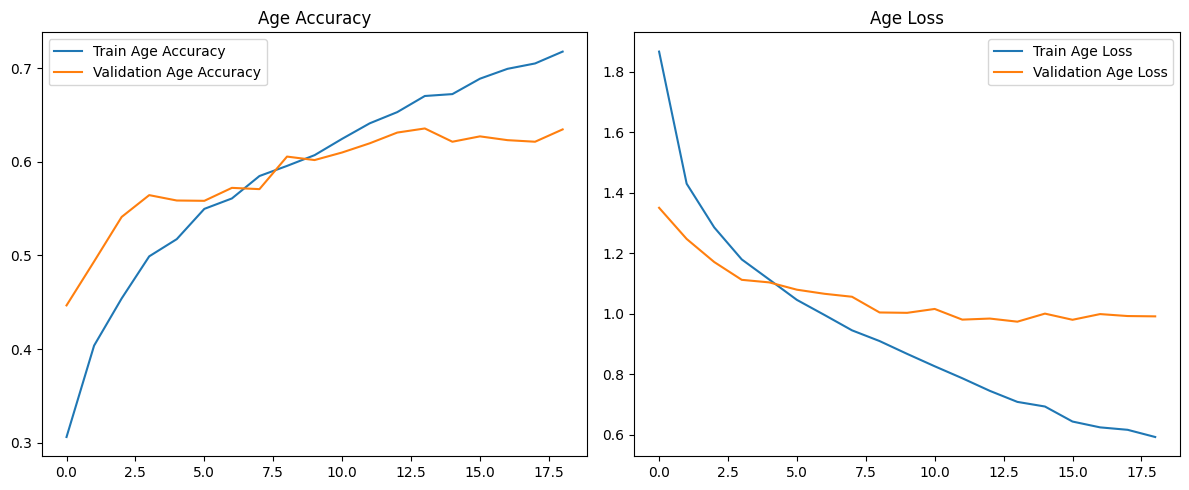

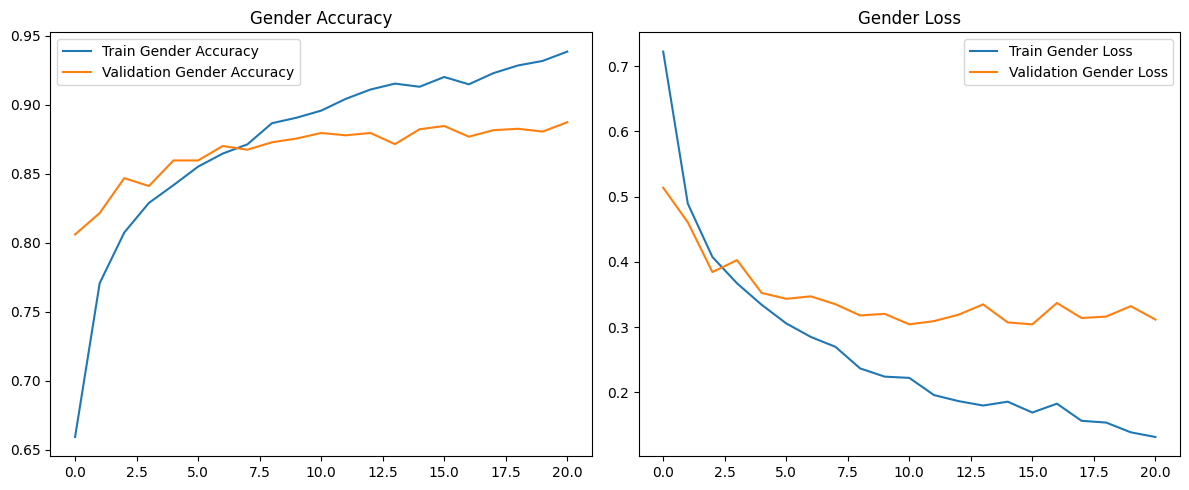

In [15]:
plt.figure(figsize=(12, 5))

# Age accuracy
plt.subplot(1, 2, 1)
plt.plot(age_history.history['accuracy'], label='Train Age Accuracy')
plt.plot(age_history.history['val_accuracy'], label='Validation Age Accuracy')
plt.title('Age Accuracy')
plt.legend()

# Age loss
plt.subplot(1, 2, 2)
plt.plot(age_history.history['loss'], label='Train Age Loss')
plt.plot(age_history.history['val_loss'], label='Validation Age Loss')
plt.title('Age Loss')
plt.legend()

plt.tight_layout()
plt.savefig('age_training_history.png')
plt.show()

# Visualize training history for gender model
plt.figure(figsize=(12, 5))

# Gender accuracy
plt.subplot(1, 2, 1)
plt.plot(gender_history.history['accuracy'], label='Train Gender Accuracy')
plt.plot(gender_history.history['val_accuracy'], label='Validation Gender Accuracy')
plt.title('Gender Accuracy')
plt.legend()

# Gender loss
plt.subplot(1, 2, 2)
plt.plot(gender_history.history['loss'], label='Train Gender Loss')
plt.plot(gender_history.history['val_loss'], label='Validation Gender Loss')
plt.title('Gender Loss')
plt.legend()

plt.tight_layout()
plt.savefig('gender_training_history.png')
plt.show()

### Example of how to load the model and use it for prediction

In [16]:
def predict_age_and_gender(image_path):
    """
    Load pre-trained models and predict age and gender from an image.
    
    Args:
        image_path (str): Path to the image file
    
    Returns:
        tuple: (age_range, gender) as strings
    """
    import numpy as np
    import os
    import joblib
    from tensorflow.keras.models import load_model
    from img2vec import grayscale2emb  # Your feature extraction function
    
    # Check if the image exists
    if not os.path.exists(image_path):
        return "Error: Image not found"
    
    # Load the models
    try:
        age_model = load_model('age_model.h5')
        gender_model = load_model('gender_model.h5')
    except Exception as e:
        return f"Error loading models: {str(e)}"
    
    # Load the encoders
    try:
        age_encoder = joblib.load('age_encoder.pkl')
        gender_encoder = joblib.load('gender_encoder.pkl')
        scaler = joblib.load('feature_scaler.pkl')
    except Exception as e:
        return f"Error loading encoders: {str(e)}"
    
    # Extract features from the image
    try:
        # Convert to batch format (list with single image)
        features = grayscale2emb([image_path])
        
        # Scale features
        features_scaled = scaler.transform(features)
        
        # Make predictions
        age_pred = np.argmax(age_model.predict(features_scaled), axis=1)[0]
        gender_pred = np.argmax(gender_model.predict(features_scaled), axis=1)[0]
        
        # Convert numerical predictions to original labels
        age_range = age_encoder.inverse_transform([age_pred])[0]
        gender = gender_encoder.inverse_transform([gender_pred])[0]
        
        return (age_range, gender)
    
    except Exception as e:
        return f"Error during prediction: {str(e)}"

# Example usage:
age_range, gender = predict_age_and_gender("../../img.jpg")
print(f"Predicted Age Range: {age_range}")
print(f"Predicted Gender: {gender}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Predicted Age Range: (38, 43)
Predicted Gender: m
